# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices
from relaxed.models import training_suite
from relaxed import halo_catalogs

# Data

In [6]:
mah_data = get_mah('m12', '../../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [7]:
# catalog
cat = mah_data['cat']
xoff = cat['xoff']
cvir = cat['cvir']
eta = cat['eta']
ma = mah_data['ma']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [9]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [11]:
# train/test split
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.3)
cat_train, am_train, cvir_train, xoff_train, eta_train = (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                           xoff[train_idx], eta[train_idx])
cat_test, am_test, cvir_test, xoff_test, eta_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                     xoff[test_idx], eta[test_idx])
print(cvir_train.shape, cvir_test.shape)

(7000,) (3000,)


# Train

In [15]:
# all cvir models are specified in data.
data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.50, 'cam_order': -1}},
    'linear': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
cvir_models = training_suite(data)

In [16]:
# eta
data = {
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.5, 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'linear': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {},
    },
}

eta_models = training_suite(data)

In [17]:
# xoff
data = {
    'cam_1/2': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.5, 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'linear': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
xoff_models = training_suite(data)

In [18]:
# joint models
y_train = np.hstack([cvir_train.reshape(-1, 1), xoff_train.reshape(-1, 1), eta_train.reshape(-1, 1)])
data ={
    'multi_gaussian': {
        'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 3, 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }, 
    'multi_linear': {
        'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 3, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }
}
joint_models = training_suite(data)

# Plots

## Combined histogram of residuals

In [26]:
from relaxed.analysis import vol_jacknife_err

def summary_statistics(model, _x_test, _y_test, box_keep = None):
    if box_keep is None:
        box_keep = np.ones(_x_test.shape[0]).astype(bool)
    
    x_test = _x_test[box_keep]
    y_test = _y_test[box_keep].reshape(-1)
    
    y_pred = model.predict(x_test).reshape(-1)
    x = (y_pred - y_test) / np.std(y_test) # normalize

    return {'mu': np.mean(x), 
            'med': np.median(x),
            'sigma_ratio': np.std(y_pred) / np.std(y_test), 
            'sigma_rratio': np.std(y_pred - y_test) / np.std(y_test), 
            'corr': scipy.stats.spearmanr(y_pred, y_test)[0],
            'scatter': np.std(x)
           }


# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", 
                       xrange=(-3, 3), figsize=(20, 10), legend_size=20, log=False, 
                       calc_errs = False, cat_test=None, draw_vline=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        assert model.n_targets == 1
        y_pred = model.predict(x_test).reshape(-1)
        x = (y_pred - y_test) / np.std(y_test) # normalize
        summ = summary_statistics(model, x_test, y_test)
          
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        label1 = f"{label}, $(\\rho, \\mu, \\mu', \\sigma_p / \\sigma_t, \\sigma_x) ="
        label2 = f"({summ['corr']:.2f}, {summ['mu']:.2f}, {summ['med']:.2f}, {summ['sigma_ratio']:.2f}, {summ['scatter']:.2f})$"

        # calculate uncertainties
        if calc_errs:
            assert cat_test is not None
            err = vol_jacknife_err(summary_statistics, cat_test, model, x_test, y_test, mode='dict')
            label2 = (f"({summ['corr']:.2f} \\pm {err['corr']:.2f}, {summ['mu']:.2f} \\pm {err['mu']:.2f},"
                     f"{summ['med']:.2f} \\pm {err['med']:.2f}, {summ['sigma_ratio']:.2f} \\pm {err['sigma_ratio']:.2f}, {summ['scatter']:.2f} \\pm {err['scatter']:.2f})$")
        label = label1 + label2

        draw_histogram(ax, x, vline=summ['mu']if draw_vline else None, label=label, color=color, bins=bins, density=False)
        
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / \\sigma({v_test})$", size=28)
    
    if log: 
        ax.set_yscale('log')
        
    if draw_vline:
        ax.axvline(0, color='k', ls='--')


        
    # format legend
    ax.legend(loc='lower left', prop={'size':legend_size}, bbox_to_anchor=(0., 1.02, 1., .202), 
              ncol=1,  borderaxespad=0.)

### Cvir

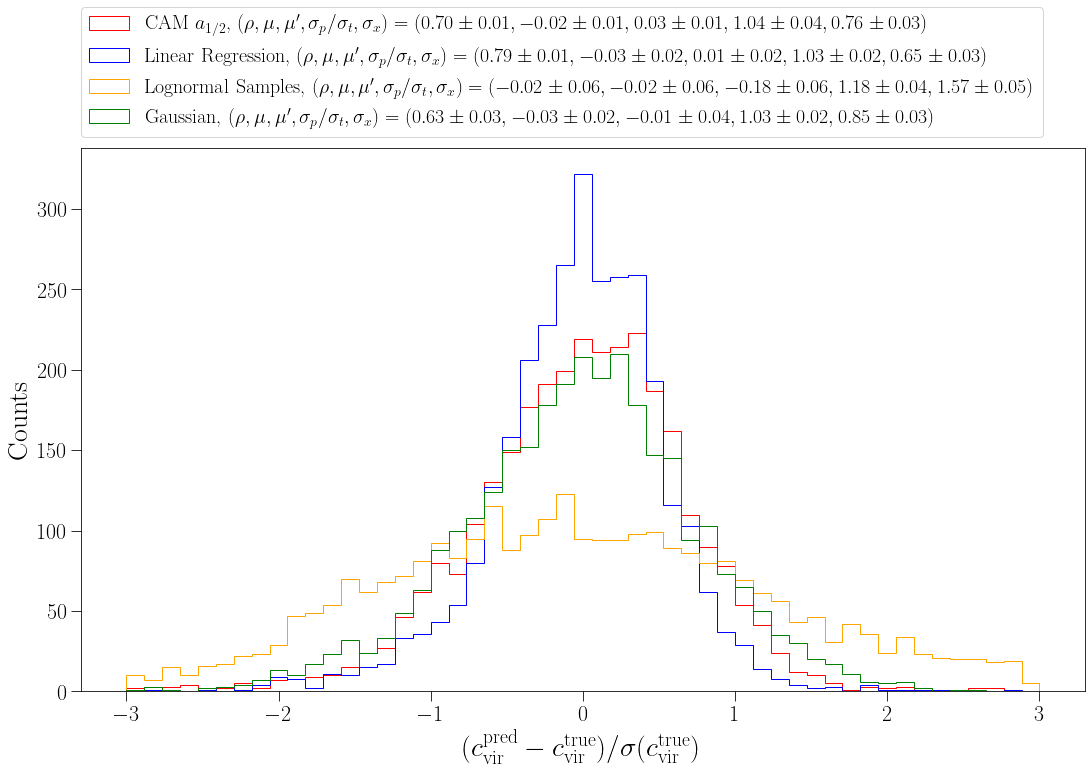

In [27]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'orange'),
            'gaussian': (am_test, "\\rm Gaussian", 'g'), 
            }

combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-3, 3), 
                   calc_errs=True, cat_test=cat_test, figsize=(18, 10), draw_vline=False)

### Xoff

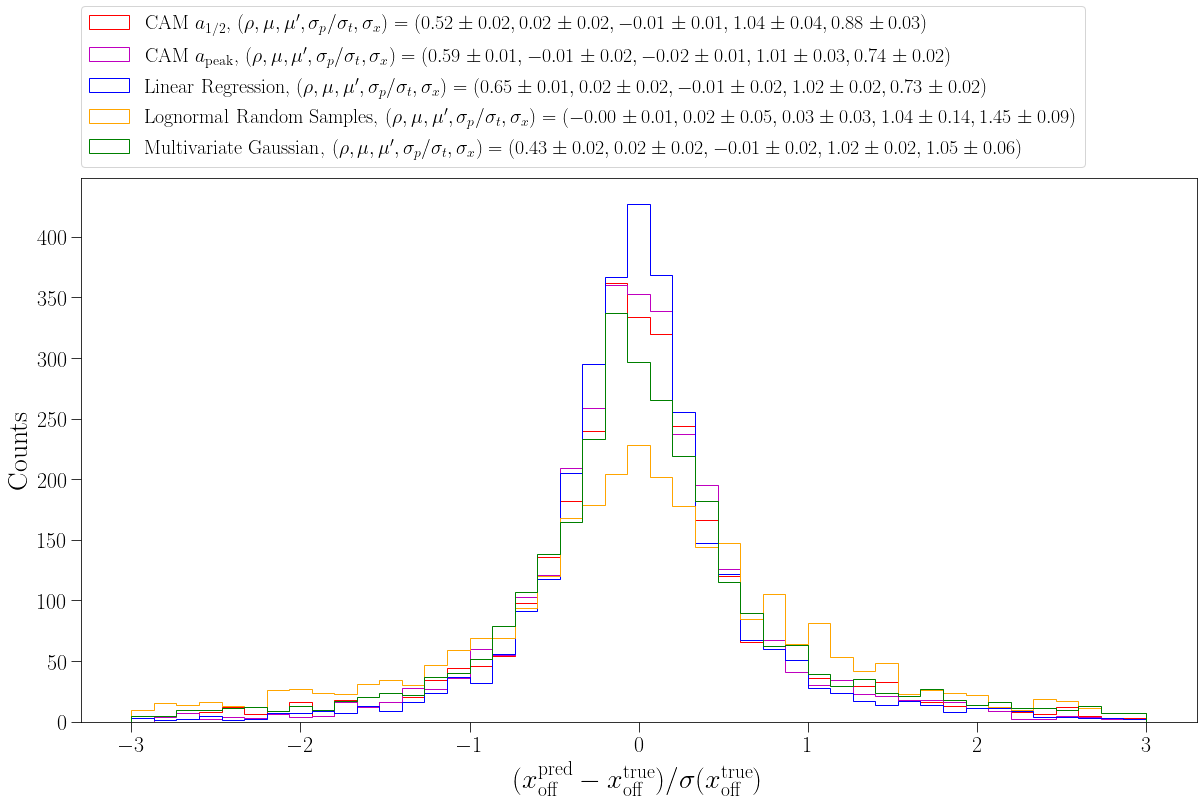

In [40]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
             'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'm'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Random Samples", 'orange'),
            'gaussian': (am_test, "\\rm Multivariate Gaussian", 'g')}
combined_histogram(test_data, xoff_test, xoff_models, latex_var=r'x_{\rm off}', n_bins=45, xrange=(-3, 3), 
                  calc_errs=True, cat_test=cat_test, draw_vline=False)

### eta

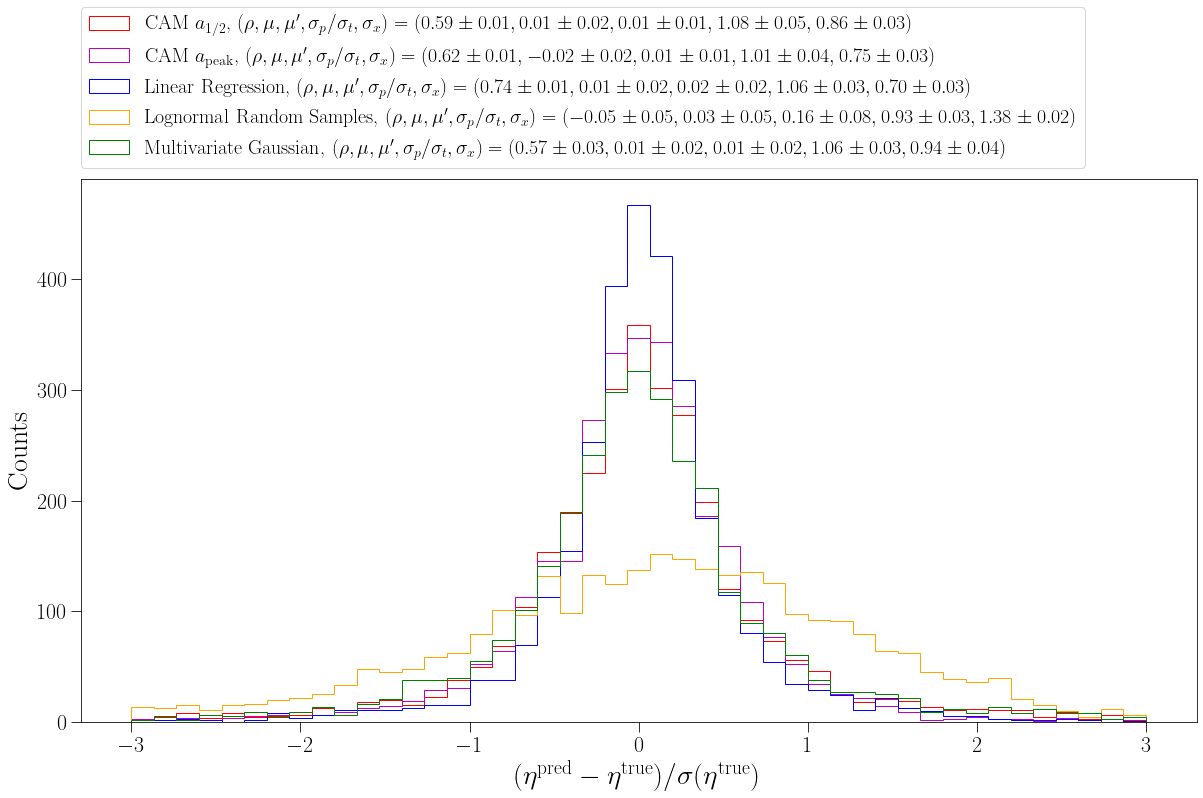

In [41]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
             'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'm'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Random Samples", 'orange'),
            'gaussian': (am_test, "\\rm Multivariate Gaussian", 'g')}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=45, xrange=(-3, 3), 
                  calc_errs=True, cat_test=cat_test, draw_vline=False)

## Invidual predicted distributions for c_vir for different models

Text(0, 0.5, '\\rm Counts')

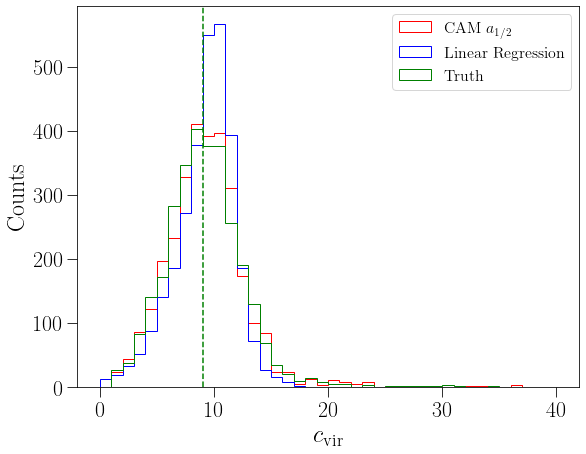

In [77]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            }
#             'lognormal': (am_test, "\\rm Lognormal Samples", 'orange'),
#             'gaussian': (am_test, "\\rm Gaussian (Untransformed)", 'g')}

fig, ax = plt.subplots(1,1, figsize=(9, 7))
bins=None
xrange=None

for k, v in test_data.items():
    
    model = cvir_models[k]
    x_test, label, color = v
    y_pred = model.predict(x_test)
    
    if bins is None: 
        bins = get_bins(y_pred, range=(0, 40), bins=40) # share bins between all histograms.
        
    draw_histogram(ax, y_pred, vline=None, label=label, color=color, bins=bins, density=False)

    
# truth
draw_histogram(ax, cvir_test, vline='median', label='\\rm Truth', color='g', bins=bins, density=False)
ax.legend(loc='best', prop={'size':16})

ax.set_xlabel(r'$c_{\rm vir}$')
ax.set_ylabel(r'\rm Counts')

## Correlations

In [19]:
# true correlation between cvir, xoff, eta 
from scipy.stats import spearmanr

print('True Correlations:')
print("(cvir, xoff): {:3f}".format(spearmanr(cvir_test, xoff_test)[0]))
print("(cvir, eta): {:3f}".format(spearmanr(cvir_test, eta_test)[0]))
print("(xoff, eta): {:3f}".format(spearmanr(xoff_test, eta_test)[0]))

print()
print('MultiCAM Linear Regression Correlations:')
cvir_pred = cvir_models['linear'].predict(am_test).reshape(-1)
xoff_pred = xoff_models['linear'].predict(am_test).reshape(-1)
eta_pred = eta_models['linear'].predict(am_test).reshape(-1)
print("(cvir, xoff): {:3f}".format(spearmanr(cvir_pred, xoff_pred)[0]))
print("(cvir, eta): {:3f}".format(spearmanr(cvir_pred, eta_pred)[0]))
print("(xoff, eta): {:3f}".format(spearmanr(xoff_pred, eta_pred)[0]))

print()
print('CAM Correlations:')
cvir_pred = cvir_models['cam_1/2'].predict(am_test).reshape(-1)
xoff_pred = xoff_models['cam_peak'].predict(am_test).reshape(-1)
eta_pred = eta_models['cam_peak'].predict(am_test).reshape(-1)
print("(cvir, xoff): {:3f}".format(spearmanr(cvir_pred, xoff_pred)[0]))
print("(cvir, eta): {:3f}".format(spearmanr(cvir_pred, eta_pred)[0]))
print("(xoff, eta): {:3f}".format(spearmanr(xoff_pred, eta_pred)[0]))

print()
print('Conditional Gaussian Samples Correlations:')
cvir_pred = cvir_models['gaussian'].predict(am_test).reshape(-1)
xoff_pred = xoff_models['gaussian'].predict(am_test).reshape(-1)
eta_pred = eta_models['gaussian'].predict(am_test).reshape(-1)
print("(cvir, xoff): {:3f}".format(spearmanr(cvir_pred, xoff_pred)[0]))
print("(cvir, eta): {:3f}".format(spearmanr(cvir_pred, eta_pred)[0]))
print("(xoff, eta): {:3f}".format(spearmanr(xoff_pred, eta_pred)[0]))


print()
print('Conditional Joint Multi-Gaussian Samples Correlations:')
y_pred = joint_models['multi_gaussian'].predict(am_test)
cvir_pred, xoff_pred, eta_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
print("(cvir, xoff): {:3f}".format(spearmanr(cvir_pred, xoff_pred)[0]))
print("(cvir, eta): {:3f}".format(spearmanr(cvir_pred, eta_pred)[0]))
print("(xoff, eta): {:3f}".format(spearmanr(xoff_pred, eta_pred)[0]))

print()
print('MultiCAM Linear Regression Joint Correlations:')
y_pred = joint_models['multi_linear'].predict(am_test)
cvir_pred, xoff_pred, eta_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
print("(cvir, xoff): {:3f}".format(spearmanr(cvir_pred, xoff_pred)[0]))
print("(cvir, eta): {:3f}".format(spearmanr(cvir_pred, eta_pred)[0]))
print("(xoff, eta): {:3f}".format(spearmanr(xoff_pred, eta_pred)[0]))

True Correlations:
(cvir, xoff): -0.635262
(cvir, eta): -0.617291
(xoff, eta): 0.645068

MultiCAM Linear Regression Correlations:
(cvir, xoff): -0.919455
(cvir, eta): -0.943507
(xoff, eta): 0.964349

CAM Correlations:
(cvir, xoff): -0.590458
(cvir, eta): -0.590532
(xoff, eta): 0.999997

Conditional Gaussian Samples Correlations:
(cvir, xoff): -0.476557
(cvir, eta): -0.554278
(xoff, eta): 0.466910

Conditional Joint Multi-Gaussian Samples Correlations:
(cvir, xoff): -0.630648
(cvir, eta): -0.588749
(xoff, eta): 0.610569

MultiCAM Linear Regression Joint Correlations:
(cvir, xoff): -0.919455
(cvir, eta): -0.943507
(xoff, eta): 0.964349


## Correlations with errors

In [104]:
import tqdm
N = 200
rhos = {'test': np.zeros((N, 3)), 'joint': np.zeros((N,3)), 'train': np.zeros((N, 3))}

for i in tqdm.tqdm(range(N)):

    # train/test split.
    train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.3)

    cat_train, am_train, cvir_train, xoff_train, eta_train =  (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                              xoff[train_idx], eta[train_idx])
    cat_test, am_test, cvir_test, xoff_test, eta_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                              xoff[test_idx], eta[test_idx], )
    
    # train
    rhos['train'][i, 0] = spearmanr(cvir_train, xoff_train)[0]
    rhos['train'][i, 1] = spearmanr(cvir_train, eta_train)[0]
    rhos['train'][i, 2] = spearmanr(xoff_train, eta_train)[0]
    
    # test
    rhos['test'][i, 0] = spearmanr(cvir_test, xoff_test)[0]
    rhos['test'][i, 1] = spearmanr(cvir_test, eta_test)[0]
    rhos['test'][i, 2] = spearmanr(xoff_test, eta_test)[0]
    
    # joint model    
    y_train = np.hstack([cvir_train.reshape(-1, 1), xoff_train.reshape(-1, 1), eta_train.reshape(-1, 1)])
    data ={
        'multi_gaussian': {
            'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 3, 'model': 'gaussian',
            'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
        }
    }
    joint_models = training_suite(data)
    joint_model = joint_models['multi_gaussian']
    
    y_pred = joint_models['multi_gaussian'].predict(am_test)
    cvir_pred, xoff_pred, eta_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    
    rhos['joint'][i, 0] = spearmanr(cvir_pred, xoff_pred)[0]
    rhos['joint'][i, 1] = spearmanr(cvir_pred, eta_pred)[0]
    rhos['joint'][i, 2] = spearmanr(xoff_pred, eta_pred)[0]

100%|██████████| 200/200 [19:31<00:00,  5.86s/it]


In [107]:
corr_names = ('(cvir, xoff)', '(cvir, eta)', '(xoff, eta)')
for m in ('train', 'test', 'joint'):
    Rho = rhos[m]
    print(f'{m}:')
    for k, name in enumerate(corr_names):
        print(f'{name}: mean={np.mean(Rho[:, k]):.3f}, std={np.std(Rho[:, k]):.3f}')
    print()

train:
(cvir, xoff): mean=-0.630, std=0.004
(cvir, eta): mean=-0.610, std=0.005
(xoff, eta): mean=0.639, std=0.004

test:
(cvir, xoff): mean=-0.631, std=0.010
(cvir, eta): mean=-0.609, std=0.011
(xoff, eta): mean=0.640, std=0.010

joint:
(cvir, xoff): mean=-0.614, std=0.012
(cvir, eta): mean=-0.600, std=0.012
(xoff, eta): mean=0.613, std=0.012



## Scatter plots of residuals

In [55]:
def scatter_plots(test_data: dict, y_test, trained_models, a_peak_test, alpha=0.5, latex_var=""): 
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = y_pred / y_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        ax1.scatter(y_test, x, alpha=alpha, color=color, label=label)
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        
        
        ax2.scatter(y_pred, x, alpha=alpha, color=color, label=label)
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        ax3.scatter(a_peak_test, x, alpha=alpha, color=color, label=label)
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # add median line
        print(f'median {name}: ', np.median(x))
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

median cam_1/2:  1.0037486536110318
median multicam:  1.008433264444383


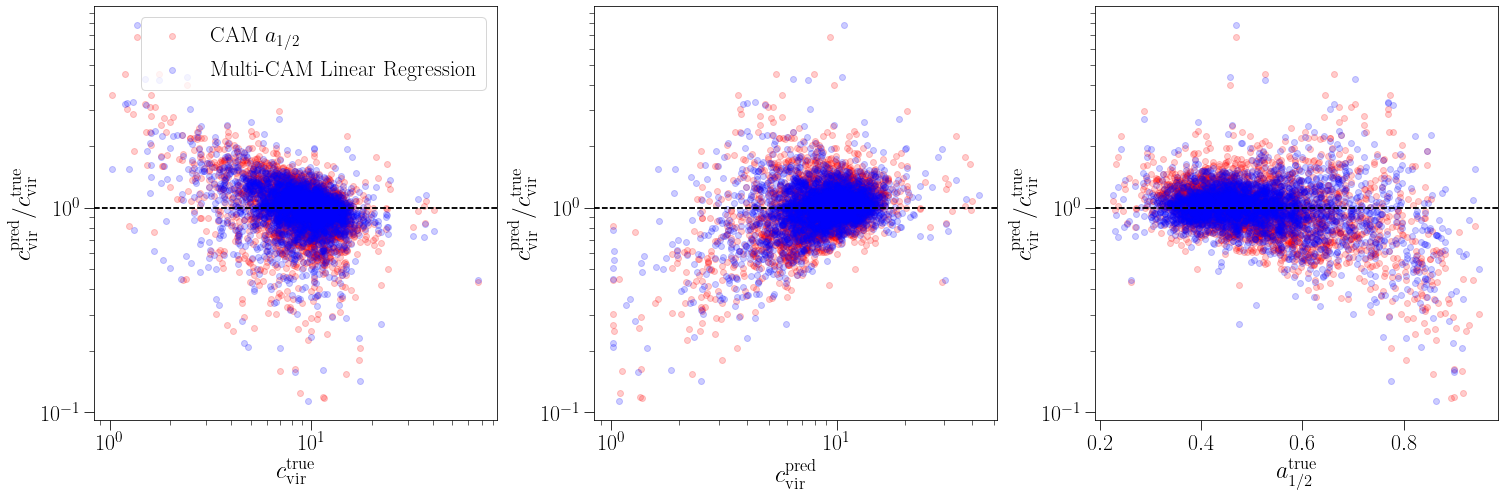

In [56]:
from relaxed.analysis import get_an_from_am
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'multicam': (am_test, "\\rm Multi-CAM Linear Regression", 'b'),}
a_2_test = get_an_from_am(am_test, mass_bins, mbin=0.498)
scatter_plots(test_data, cvir_test, cvir_models, a_2_test, alpha=0.2, latex_var=r'c_{\rm vir}')

## Median bin statistic

In [57]:
def make_scatter_binning(ax, x, y, n_xbins=15, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    ax.errorbar(
        xmeds,
        ymeds,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

In [58]:
def median_bin_statistic(test_data, y_test, trained_models, a_peak_test, log_scale=True, latex_var=""):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = y_pred / y_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        make_scatter_binning(ax1, y_test, x, color=color, label=label)
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        

        make_scatter_binning(ax2, y_pred, x, color=color, label=label)
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        make_scatter_binning(ax3, a_peak_test, x, color=color, label=label)
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # visual guides.
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        if log_scale: 
            # set scales.
            ax1.set_xscale('log')
            ax2.set_xscale('log')

            ax1.set_yscale('log')
            ax2.set_yscale('log')
            ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

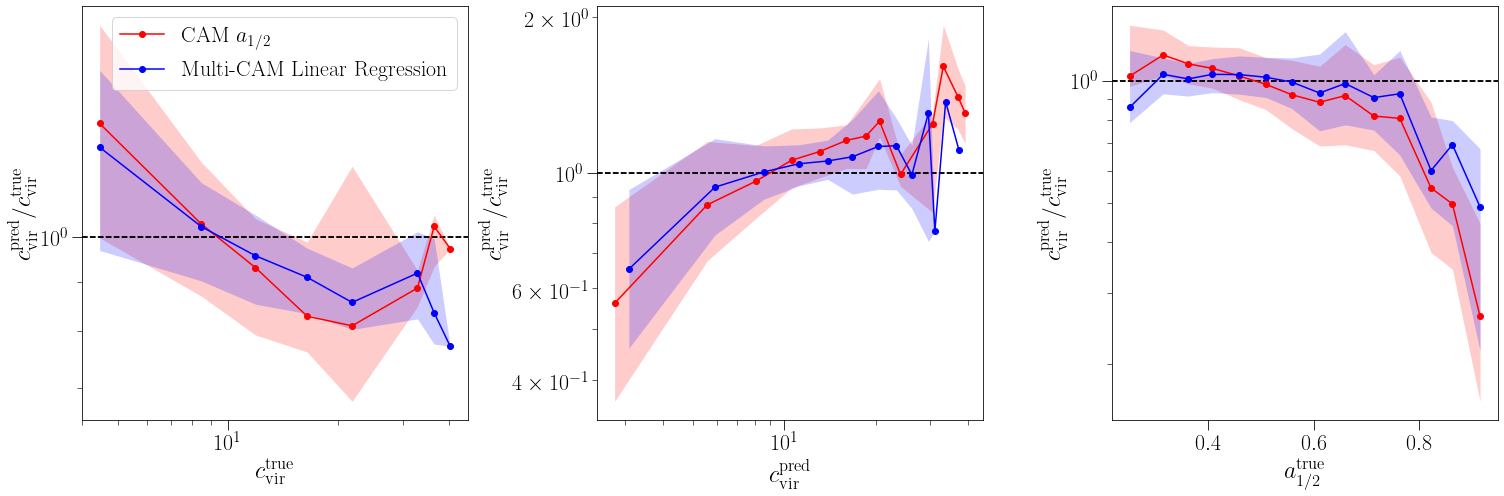

In [59]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'multicam': (am_test, "\\rm Multi-CAM Linear Regression", 'b'),}
a_2_test = get_an_from_am(am_test, mass_bins, mbin=0.498)
median_bin_statistic(test_data, cvir_test, cvir_models, a_2_test, latex_var=r'c_{\rm vir}')

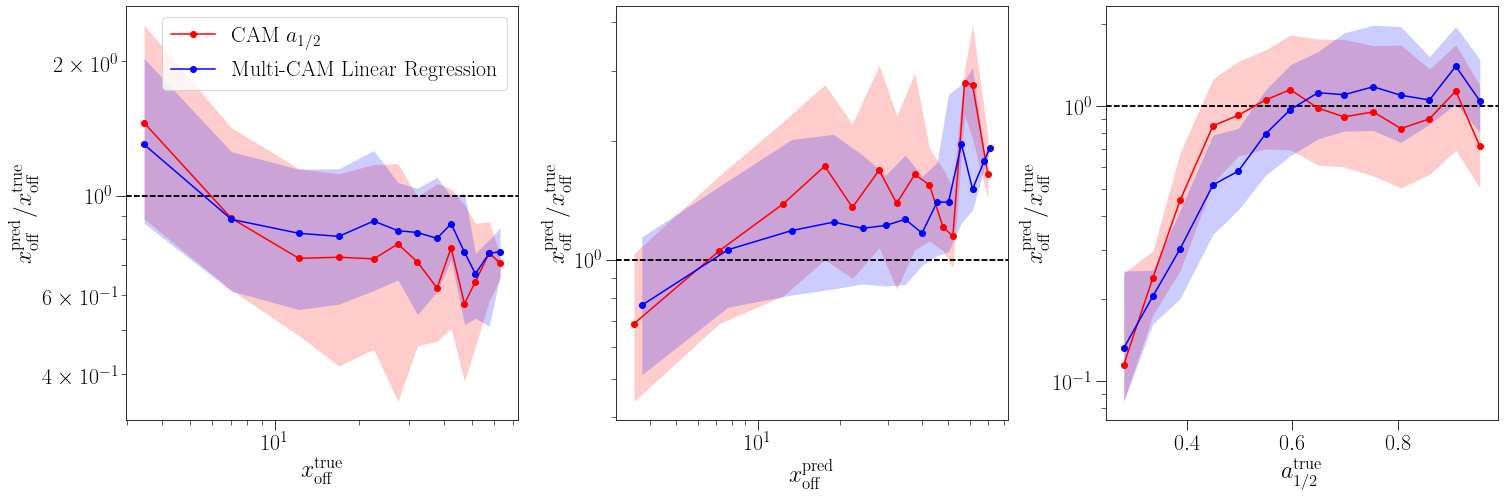

In [61]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'multicam': (am_test, "\\rm Multi-CAM Linear Regression", 'b'),}
a_peak_test = get_an_from_am(am_test, mass_bins, mbin=0.738)
median_bin_statistic(test_data, xoff_test, xoff_models, a_peak_test, latex_var=r'x_{\rm off}')

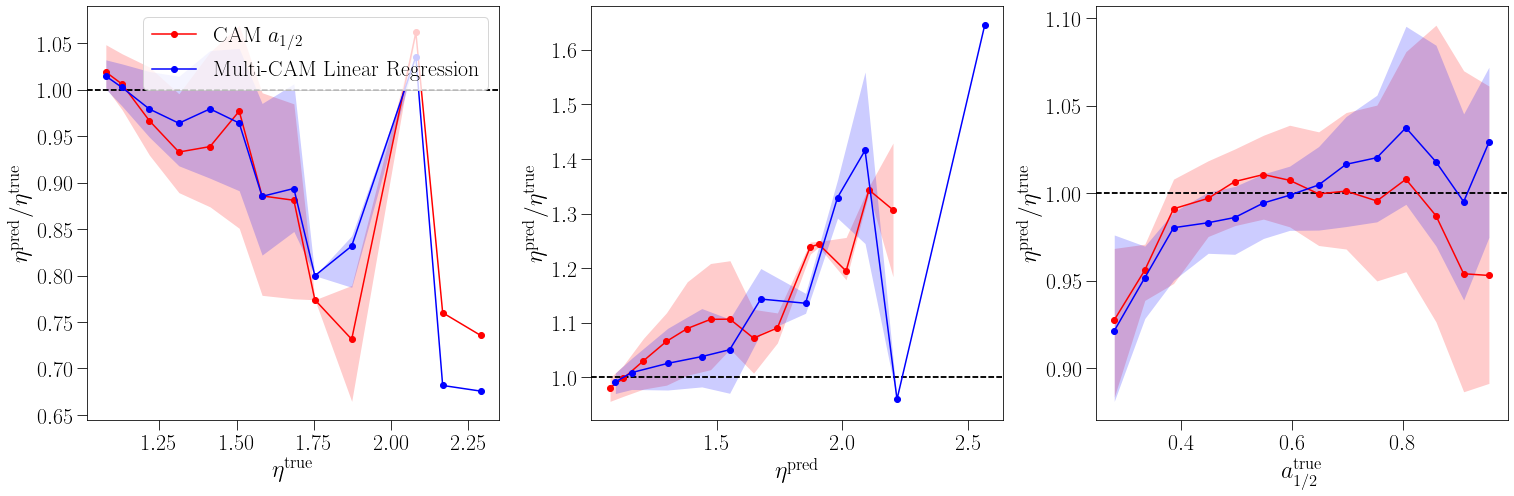

In [62]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'multicam': (am_test, "\\rm Multi-CAM Linear Regression", 'b'),}
a_peak_test = get_an_from_am(am_test, mass_bins, mbin=0.738)
median_bin_statistic(test_data, eta_test, eta_models, a_peak_test, latex_var=r'\eta', log_scale=False)

# Toy Gaussian 

In [110]:
mean = [0, 0]
cov = [[1, 0.9], [0.9, 1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000000).T
x =x.reshape(-1, 1)

0.9992966493408818


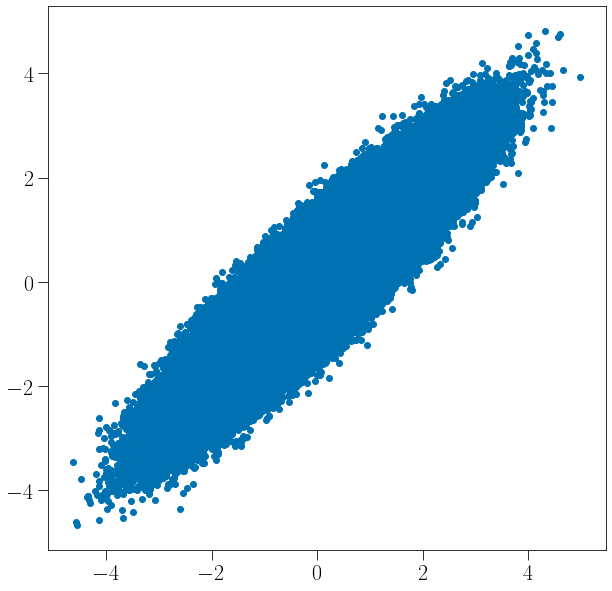

In [111]:
plt.scatter(x,y)
print(np.std(y))

In [112]:
# all cvir models are specified in data.
x_train, y_train = x[train_idx], y[train_idx]
x_test, y_test = x[test_idx], y[test_idx]
data = {
    'gaussian_no_transform': {
        'xy': (x_train, y_train), 'n_features': x_train.shape[1], 'model': 'gaussian', 'kwargs': {'use_qt':False, 'use_logs':False}
    }
}
toy_model = training_suite(data)


In [115]:
np.sqrt(toy_model['gaussian_no_transform'].sigma_cond)

array([[0.42904448]])

In [117]:
mu_bar = toy_model['gaussian_no_transform'].predict(x_test)
sigma_bar = toy_model['gaussian_no_transform'].sigma_cond
pred_samples = mu_bar + np.sqrt(sigma_bar) * np.random.randn(len(x_test))


print(np.std(pred_samples))
print(np.sqrt(toy_model['gaussian_no_transform'].sigma_cond.item()))

0.9724422140606546
0.42904447842579657
